In [2]:
from helpers import get_client, get_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
es = get_client()  
up_lul = get_data("aggregated-curr-ulping-*", es)
down_lul = get_data("aggregated-curr-dlping-*", es)

Connected to Elasticsearch.


In [4]:
# 1) compute each 95th‐percentile threshold on the raw data
lul_up_q95   = up_lul  ['rtt_avg'].quantile(0.95)
lul_down_q95 = down_lul['rtt_avg'].quantile(0.95)

# 2) filter each Series to only keep values ≤ its 95th percentile
lul_up_clipped   = up_lul.loc[up_lul['rtt_avg']     <= lul_up_q95,   'rtt_avg']
lul_down_clipped = down_lul.loc[down_lul['rtt_avg'] <= lul_down_q95, 'rtt_avg']


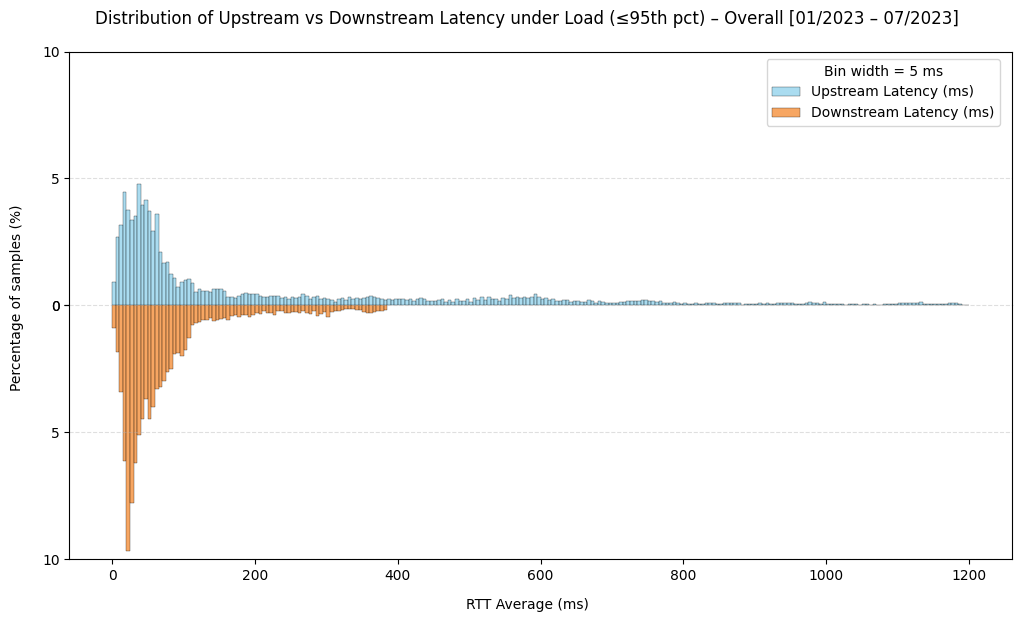

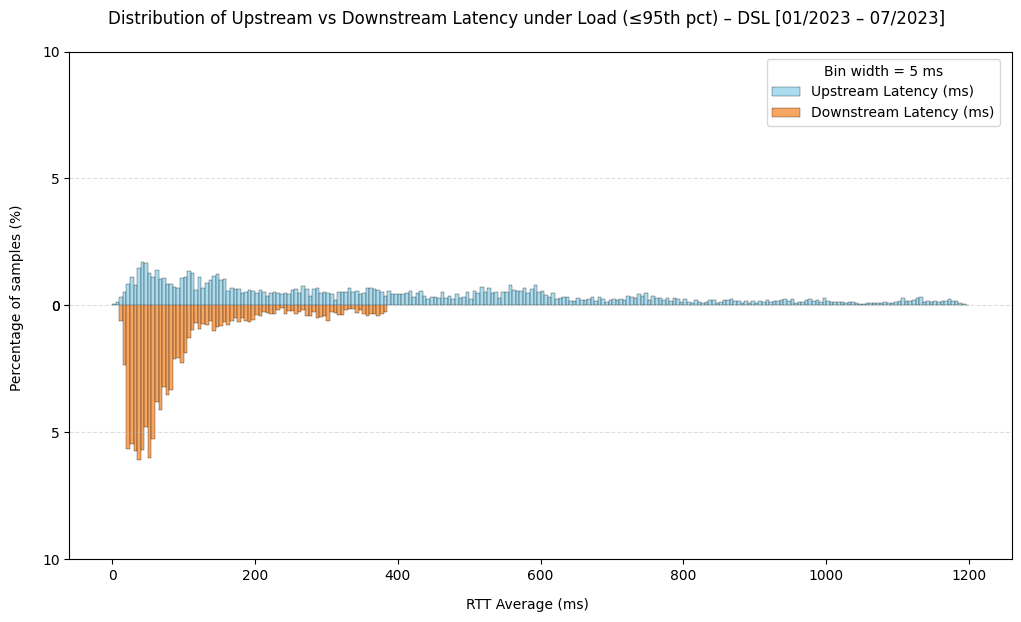

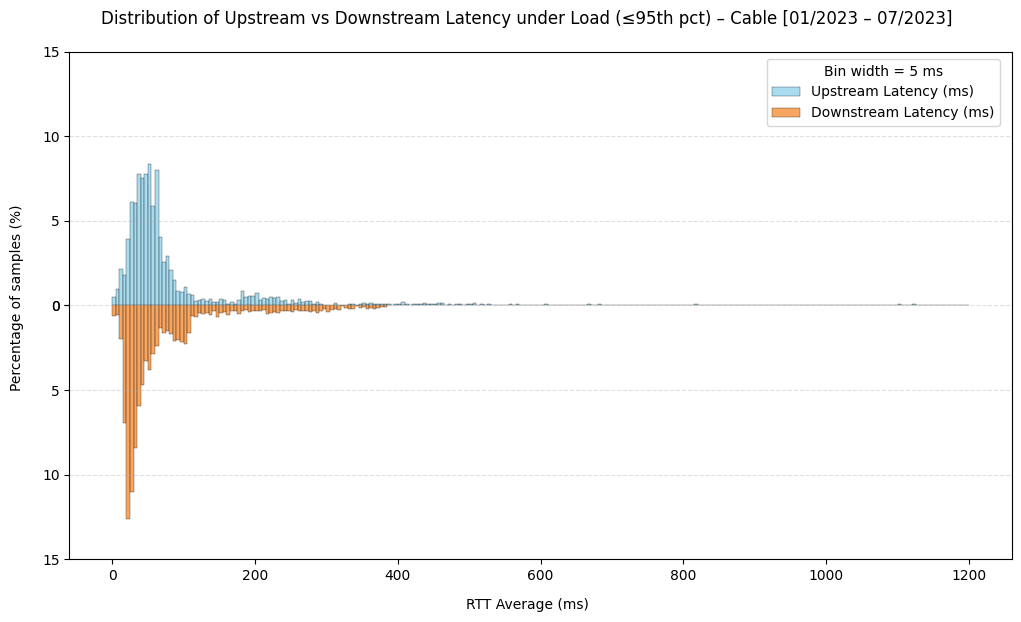

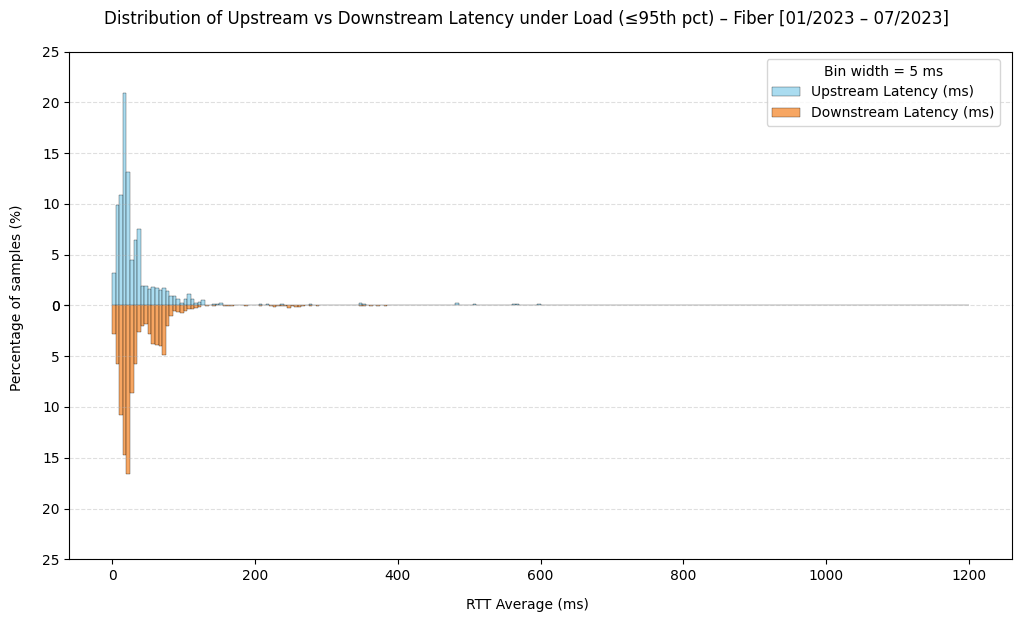

In [5]:
# ------------------------------------------------------------------
# 1.  FILTER TO YEAR-2023
# ------------------------------------------------------------------
for _df in (up_lul, down_lul):
    _df['date'] = pd.to_datetime(_df['date'])        # ensure datetime dtype

up_2023 = up_lul[up_lul['date'].dt.year == 2023].copy()
down_2023 = down_lul[down_lul['date'].dt.year == 2023].copy()

# Month/year span for the plot titles
start_str = min(up_2023['date'].min(),
                down_2023['date'].min()).strftime('%m/%Y')
end_str   = max(up_2023['date'].max(),
                down_2023['date'].max()).strftime('%m/%Y')

# ------------------------------------------------------------------
# 2.  GLOBAL 95th-PERCENTILE THRESHOLDS & BIN EDGES
# ------------------------------------------------------------------
bin_width = 5  # ms

up_q95     = up_2023['rtt_avg'].quantile(0.95)
lul_down_q95 = down_2023['rtt_avg'].quantile(0.95)

lo = np.floor(
        min(up_2023['rtt_avg'].min(),
            down_2023['rtt_avg'].min()) / bin_width
     ) * bin_width
hi = np.ceil(
        max(up_q95, lul_down_q95) / bin_width
     ) * bin_width

edges = np.arange(lo, hi + bin_width, bin_width)   # inclusive upper edge

# ------------------------------------------------------------------
# 3.  LOOP OVER 'Overall' + EACH TECHNOLOGY
# ------------------------------------------------------------------
tech_list = ['Overall', 'DSL', 'Cable', 'Fiber']

for tech in tech_list:
    # ------------- subset rows -----------------------------------
    if tech == 'Overall':
        up_tmp = up_2023
        down_tmp = down_2023
    else:
        up_tmp = up_2023[up_2023['operator_technology'] == tech]
        down_tmp = down_2023[down_2023['operator_technology'] == tech]

    # ------------- clip to global 95th percentile -----------------
    up_clipped = up_tmp.loc[up_tmp['rtt_avg'] <= up_q95, 'rtt_avg']
    down_clipped = down_tmp.loc[down_tmp['rtt_avg'] <= lul_down_q95, 'rtt_avg']

    # --- if both are empty there’s nothing to show; skip ----------
    if up_clipped.empty and down_clipped.empty:
        print(f'Skipping {tech}: no data inside 95th-percentile threshold')
        continue

    # ------------- figure & axes ---------------------------------
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, figsize=(10, 6), sharex=True,
        gridspec_kw={'height_ratios': [1, 1], 'hspace': 0}
    )

    # ------------- top histogram (Upstream latency) ------------------
    if not up_clipped.empty:
        sns.histplot(
            up_clipped, bins=edges, stat='percent',
            alpha=0.7, color='skyblue', edgecolor='black',
            ax=ax_top, label='Upstream Latency (ms)'
        )
    ax_top.grid(True, axis='y', ls='--', alpha=.4)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.tick_params(axis='x', bottom=False, labelbottom=False)
    ax_top.set_ylabel('')

    # ------------- bottom histogram (Downstream latency) ---------
    if not down_clipped.empty:
        sns.histplot(
            down_clipped, bins=edges, stat='percent',
            alpha=0.7, color='#f48120', edgecolor='black',
            ax=ax_bottom, label='Downstream Latency (ms)'
        )
    ax_bottom.invert_yaxis()
    ax_bottom.grid(True, axis='y', ls='--', alpha=.4)
    ax_bottom.spines['top'].set_visible(False)
    ax_bottom.set_xlabel('')
    ax_bottom.set_ylabel('')

    # ------------- lock y-ranges safely --------------------------
        # --- compute the maximum % so we can force both axes to the same limits
    heights_top  = [p.get_height() for p in ax_top.patches]
    heights_bot  = [p.get_height() for p in ax_bottom.patches]
    max_up   = max(heights_top) if heights_top else 0
    max_down = max(heights_bot) if heights_bot else 0
    y_max = max(max_up, max_down, 1)      # fallback to 1% so it's never flat

    # --- force identical y‐limits
    ax_top.set_ylim(0, y_max)
    ax_bottom.set_ylim(y_max, 0)          # invert=True is already in place

    # --- pick your tick step (here every 5% up to y_max)
    tick_step = 5
    yticks = np.arange(0, y_max + tick_step, tick_step)

    # --- apply the same tick locations
    ax_top.set_yticks(yticks)
    ax_bottom.set_yticks(yticks)


    # ------------- shared labels & legend ------------------------
    fig.text(0.5, 0, 'RTT Average (ms)', ha='center', va='top')
    fig.text(-0.01, 0.5, 'Percentage of samples (%)',
             ha='center', va='center', rotation='vertical')

    handles_top, labels_top = ax_top.get_legend_handles_labels()
    handles_bottom, labels_bottom = ax_bottom.get_legend_handles_labels()
    fig.legend(
        handles_top + handles_bottom,
        labels_top  + labels_bottom,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.91),
        title='Bin width = 5 ms'
    )

    plt.suptitle(
        f'Distribution of Upstream vs Downstream Latency under Load (≤95th pct) – {tech} '
        f'[{start_str} – {end_str}]'
    )
    plt.tight_layout()
    fname = (
        './plots/latency/upstream_vs_downstream/'
        f'upstream_vs_downstream_latency_{tech.lower().replace(" ", "_")}.png'
    )
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    plt.show()

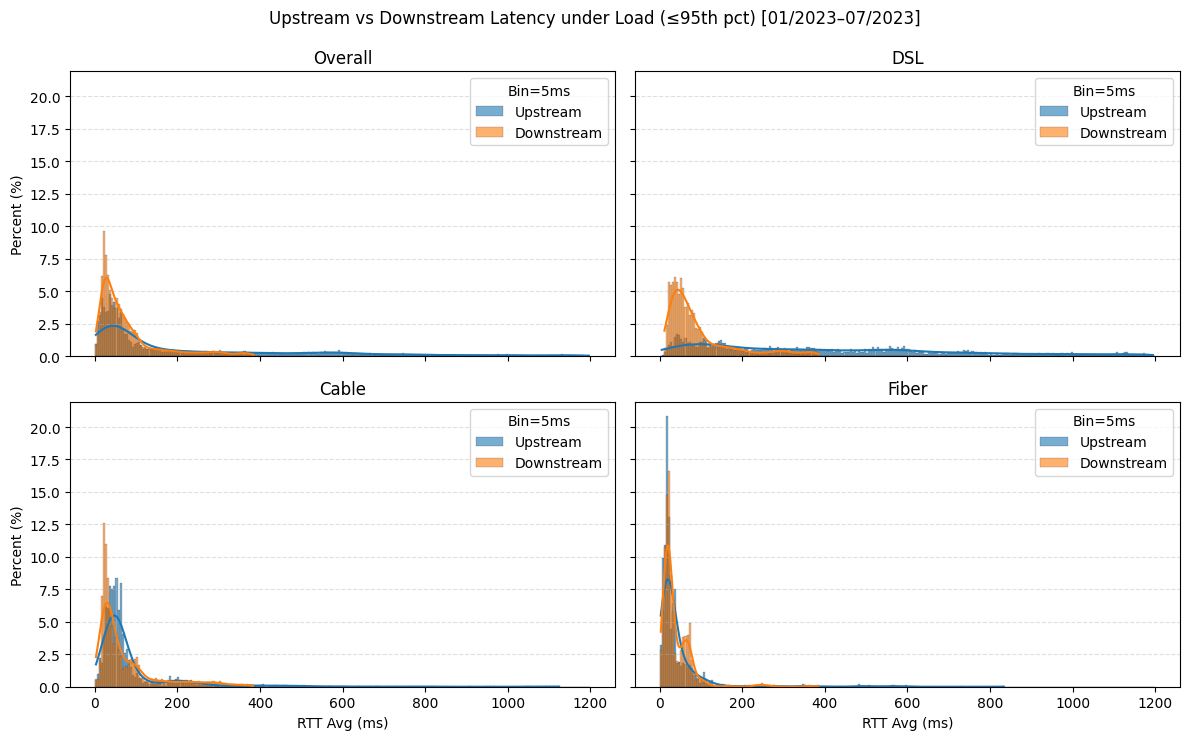

In [6]:
# global 95th-percentile thresholds & bin edges
bin_width = 5  # ms
up_q95       = up_2023['rtt_avg'].quantile(0.95)
lul_down_q95 = down_2023['rtt_avg'].quantile(0.95)

lo = (np.floor(min(up_2023['rtt_avg'].min(),
                   down_2023['rtt_avg'].min()) / bin_width)
      * bin_width)
hi = (np.ceil(max(up_q95, lul_down_q95) / bin_width)
      * bin_width)
edges = np.arange(lo, hi + bin_width, bin_width)

# determine month/year span for overall suptitle
start_str = min(up_2023['date'].min(), down_2023['date'].min()).strftime('%m/%Y')
end_str   = max(up_2023['date'].max(), down_2023['date'].max()).strftime('%m/%Y')

tech_list = ['Overall', 'DSL', 'Cable', 'Fiber']

# --- create one figure with 2x2 subplots, share x and y among all ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, tech in zip(axes, tech_list):
    # subset
    if tech == 'Overall':
        up_tmp = up_2023
        down_tmp = down_2023
    else:
        up_tmp = up_2023[up_2023['operator_technology'] == tech]
        down_tmp = down_2023[down_2023['operator_technology'] == tech]

    # clip to respective 95th pct
    up_clip = up_tmp[up_tmp['rtt_avg'] <= up_q95]['rtt_avg']
    down_clip = down_tmp[down_tmp['rtt_avg'] <= lul_down_q95]['rtt_avg']

    # plot both on the same axes
    if not up_clip.empty:
        sns.histplot(up_clip, bins=edges, stat='percent', kde=True,
                     alpha=0.6, edgecolor='black',
                     label='Upstream', ax=ax)
    if not down_clip.empty:
        sns.histplot(down_clip, bins=edges, stat='percent', kde=True,
                     alpha=0.6, edgecolor='black',
                     label='Downstream', ax=ax)

    ax.set_title(tech)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_xlabel('RTT Avg (ms)')
    ax.set_ylabel('Percent (%)')
    ax.legend(title=f'Bin={bin_width}ms') 

# global figure tweaks
fig.suptitle(f'Upstream vs Downstream Latency under Load (≤95th pct) [{start_str}–{end_str}]', y=0.92)
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('./plots/latency/upstream_vs_downstream/upstream_vs_downstream_latency_consolidated.png',
            dpi=600, bbox_inches='tight')
plt.show()